In [29]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

stock_data = yf.download('TSLA', start='2021-01-01', end='2024-01-01')
stock_data.head()

c:\Users\kabil\AppData\Local\Programs\Python\Python311\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,239.820007,248.163330,239.063339,243.256668,243.256668,145914600
2021-01-05,241.220001,246.946671,239.733337,245.036667,245.036667,96735600
2021-01-06,252.830002,258.000000,249.699997,251.993332,251.993332,134100000
2021-01-07,259.209991,272.329987,258.399994,272.013336,272.013336,154496700
2021-01-08,285.333344,294.829987,279.463318,293.339996,293.339996,225166500


Text(0, 0.5, 'Prices ($)')

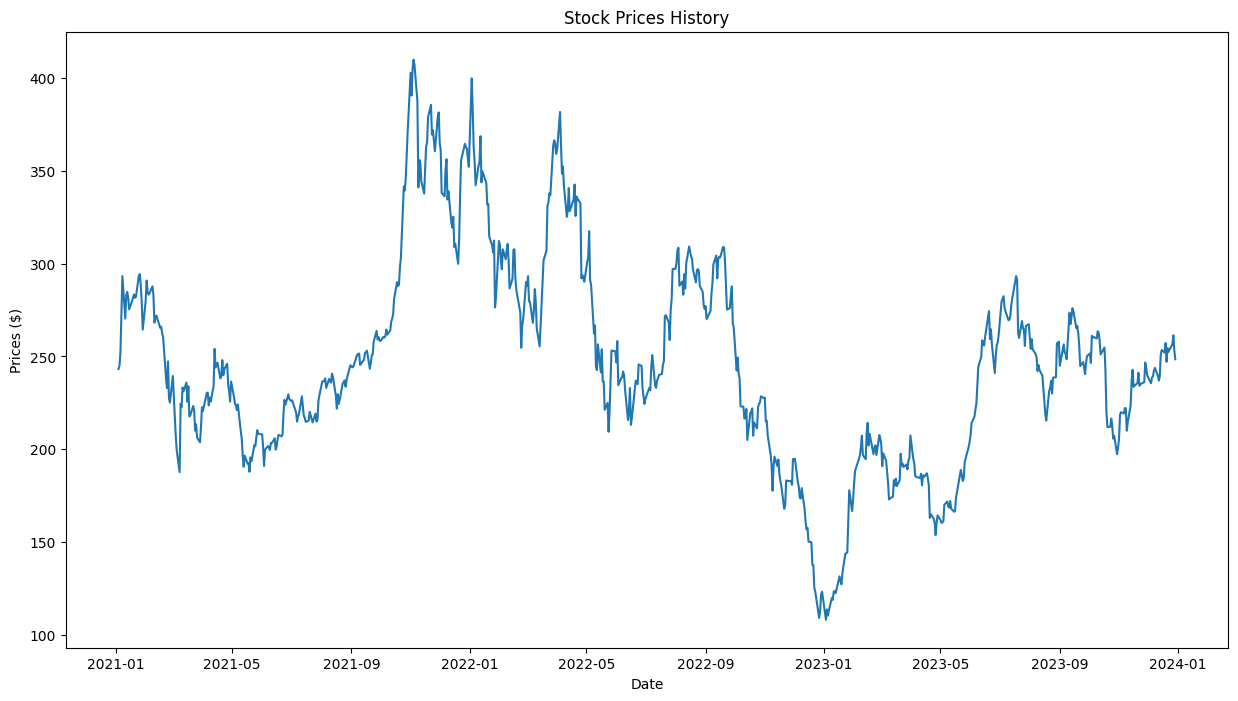

In [30]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(stock_data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [31]:
close_prices = stock_data['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [32]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [33]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 60, 100)           40800     
                                                                 
 lstm_7 (LSTM)               (None, 100)               80400     
                                                                 
 dense_6 (Dense)             (None, 25)                2525      
                                                                 
 dense_7 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123751 (483.40 KB)
Trainable params: 123751 (483.40 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
543/543 [==============================] - 17s 23ms/step - loss: 0.0068
Epoch 2/3
543/543 [==============================] - 13s 23ms/step - loss: 0.0031
Epoch 3/3
543/543 [==============================] - 11s 20ms/step - loss: 0.0024


In [35]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse


5/5 [==============================] - 1s 30ms/step


7.489361673990885

C:\Users\kabil\AppData\Local\Temp\ipykernel_3408\541213501.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


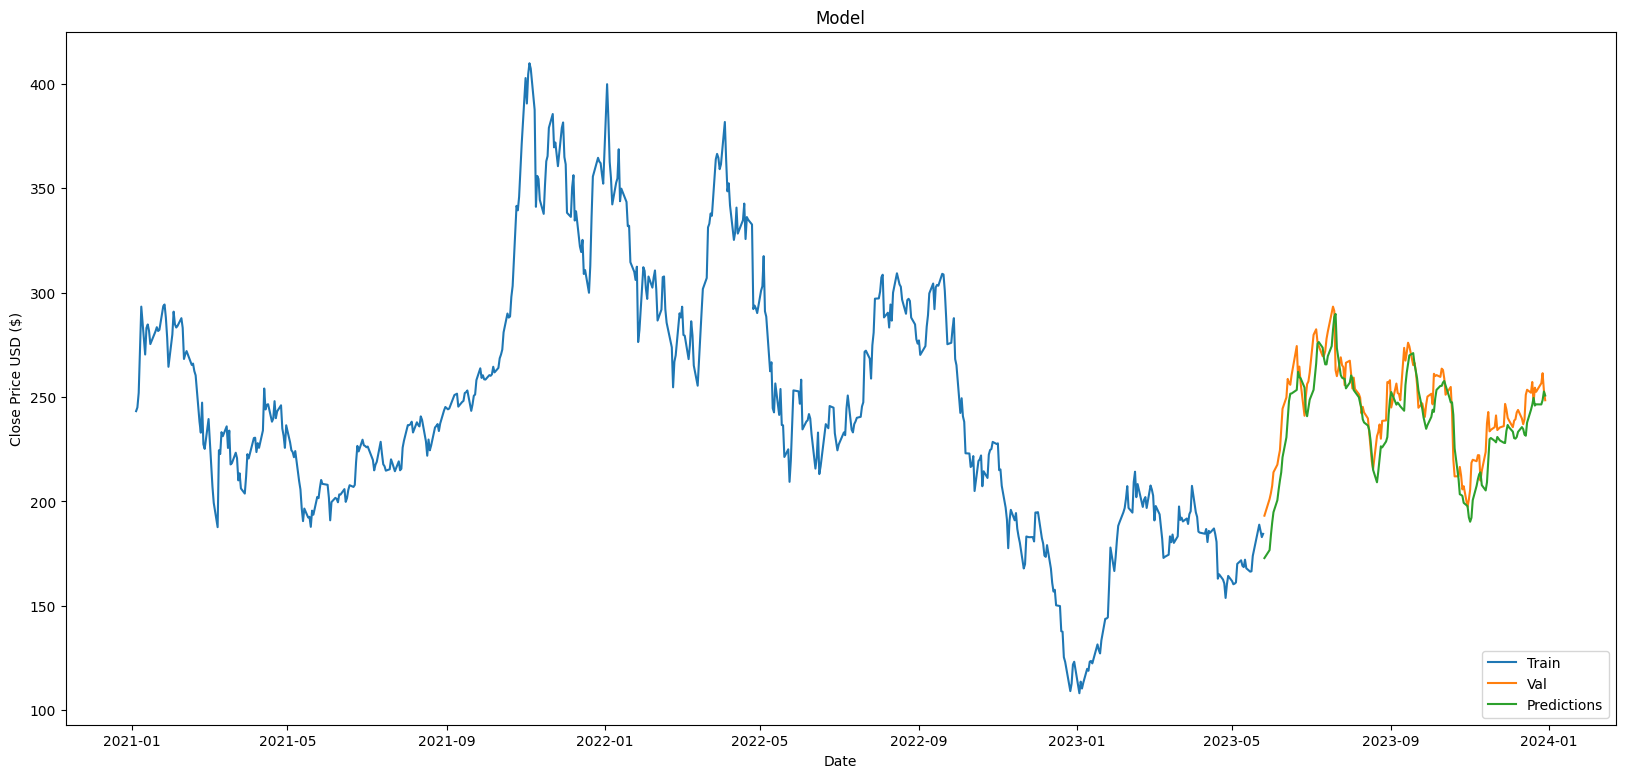

In [36]:
data = stock_data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(20,9))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()